In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from mlxtend.frequent_patterns import apriori, association_rules

# Shopping recommendation system, using Association Rules

## Intro to association rules

Association rules are great with discovering relationships between analysed items. In case of market basket analysis this method is really useful in finding co-occurences of items in different orders, which later can be helpful during implemenation of recommendation systems on website. Obviously there are many different fields where association rules can be found. This include medicine (predicting ilnesses), entertainment (movie recommendation) or law enforcement (analysing suspects profile). 

Association rules are part of unsupervised learning branch of machine learning, where data is analysed to find patterns of occurences of two or more items. These patterns comprise of two parts:
 - antecedent - item found in analysed data;
 - consequent - item found to be in relationship with antecedent.

Then dataset is analysed for frequent relationships between items, with help of different criteria like supoport, confidence or lift.

<b>Support</b> is the frequency of given item in dataset, which is calculated by following: divide number of occurences of given item by total number of items in data.

<b>Confidence</b> is the probability of finding of item in a transaction, given that other item exists in transaction.

<b>Lift is how</b> importance of a rule is measured. It is the ratio of confidence and expected confidence. The higher the lift, the greater the probability of co-occurence of given items.

## Exploratory data analysis and preparation

Our dataset contains only 3 columns:
 - Member_number - unique number that identifies customer;
 - Date - date of the transaction;
 - itemDescription - name of purchased item.

At first there is one obvious problem - there is no unique transaction id, that would describe all available baskets in dataset. This is why, transaction id will be treated as combined value of member number and date -- assumption that every customer made maximum one purchase per day.

In [2]:
data = pd.read_csv("data/Groceries_dataset.csv", encoding="unicode-escape", sep=",")  # load the data
data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


### Basic information about dataset

In [3]:
print("Number of unique items:",  len(np.unique(data.itemDescription)))  # 167 unique items
print("Number of unique customers:", len(np.unique(data.Member_number)))  # 3898 unique customers
print("Number of unique transactions:", len(np.unique(data.Member_number.astype(str) + data.Date)))  # 14963 unique transactions
print("Date range - from:", min(data.Date), " to:", max(data.Date))  # observations spanned across 22 months

Number of unique items: 167
Number of unique customers: 3898
Number of unique transactions: 14963
Date range - from: 01-01-2014  to: 31-10-2015


### Frequency of items

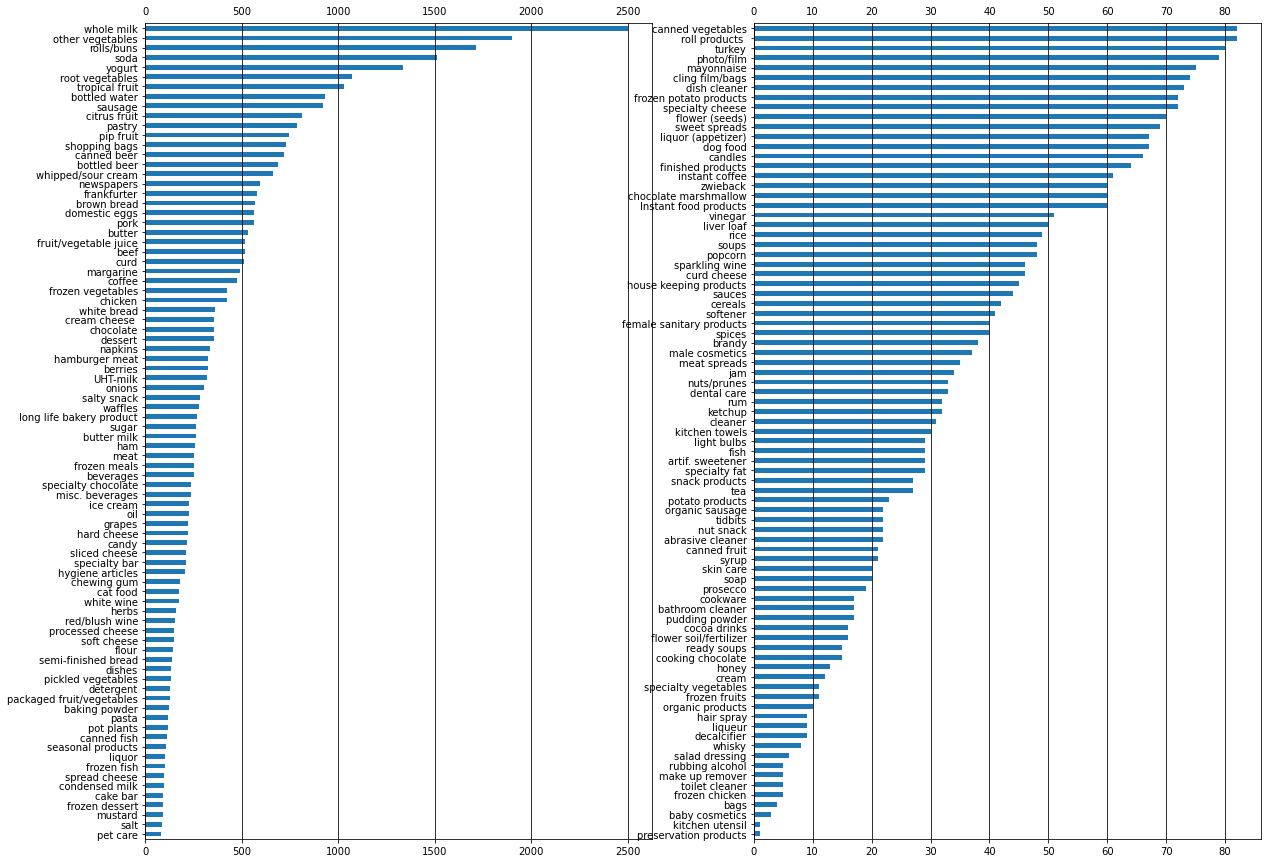

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))

data["itemDescription"].value_counts().head(84).sort_values().plot(kind="barh", ax=ax[0])  # first half of items
data["itemDescription"].value_counts().tail(83).sort_values().plot(kind="barh", ax=ax[1])  # second half of items
ax[0].grid(axis="x", color="black")
ax[0].tick_params(labelbottom=True, labeltop=True)
ax[1].grid(axis="x", color="black")
ax[1].tick_params(labelbottom=True, labeltop=True)

We can see that by far most frequent product is dairy category, which consists of milk, cheese, yogurt etc. It is present in over 8000 of transactions, which should set its support value high as it is over 50% of transactions. Other highly frequent products are daily use products as pastry, vegetables, meat or fruits. When it comes to least frequent items, we can easily see, that not many people buy organic products, or additions like vinegar, instant soups, baking powder or things for garden. Obviously there are a lot of products that I did not mention here, but the description above was intented to give you an idea how to look at these plots, and not comment on occurences of all items, as it would be pretty lengthy (30 products).

### Transform data to baskets

In this part I will transform data to look like baskets - rows will describe unique transactiond and column will describe given item. If the item B existed in transaction A, it will be annotated as 1 a the intersection of row A and column B. This will give us matrix which will be an input for apriori algorithm.

In [5]:
data_prep = data.copy()
data_prep["item"] = data_prep["itemDescription"]
data_prep["transaction"] = data_prep["Member_number"].astype(str) + " || " + data_prep["Date"]  # create unique transaction indicator as combination of date and customer number
data_prep.drop(axis=1, columns=["itemDescription", "Member_number", "Date"], inplace=True)  # drop unnecesary columns
data_prep["counter"] = 1  # counter equal to 1, as now each row describes one item purchased
data_prep.head()  # show the structure of data

,item,transaction,counter
0,tropical fruit,1808 || 21-07-2015,1
1,whole milk,2552 || 05-01-2015,1
2,pip fruit,2300 || 19-09-2015,1
3,other vegetables,1187 || 12-12-2015,1
4,whole milk,3037 || 01-02-2015,1


The transaction id was created from concatenating member number and date. This is a good way of identyfing transaction as there is low possiblity that given customer made many transaction on onde day. Also between member number and date, "<b>||</b>" was added so that if we want to split data later it will be helpful.

In [6]:
baskets = (data_prep
            .groupby(["transaction", "item"])["counter"]
            .sum()
            .unstack()
            .reset_index()
            .fillna(0)
            .set_index("transaction")
            )
print("Shape of baskets matrix:", baskets.shape)
baskets.head()  # 0 in row means that given item was not present in transaction


Shape of baskets matrix: (14963, 167)


item,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
transaction,,,,,,,,,,,,,,,,,,,,,
1000 || 15-03-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1000 || 24-06-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1000 || 24-07-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000 || 25-11-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000 || 27-05-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
baskets.describe()

item,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
count,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,...,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000,14963.000000
mean,0.004010,0.021587,0.001470,0.001938,0.000200,0.000267,0.008153,0.001136,0.034485,0.021854,...,0.005347,0.003408,0.018713,0.044242,0.000535,0.024193,0.011762,0.167212,0.089153,0.004010
std,0.063199,0.146707,0.038317,0.043983,0.014159,0.016348,0.090671,0.033689,0.185385,0.146668,...,0.072927,0.058284,0.136985,0.208224,0.023117,0.154953,0.108436,0.398805,0.296695,0.063199
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,...,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,4.000000,3.000000,1.000000


We can see above, that despite the fact that code for creating baskets works, there are some cells, where number of given item is greater than 1, and this is not allowed in apriori algorithm, so in next cell all values >= 1 are saved as 1; and all <= 0 as 0.

In [8]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = baskets.applymap(encode_units)

## Apriori

### Support of itemsets

Below support values for itemsets are calculated and then value of their support is shown on bar plots. We set the support threshold to 0.1%, which gives us 750 frequent itemsets. This was mainly due to the fact, that higher values did not allow for rules (containing itemsets of multiple items) to appear. We can also see that there are not many pairs of products present based on support criterium - only after looking below 0.01 support we can observe itemsets comprised of more than 1 item. Based on plots below we can for example say that whole milk support is ~ 0.16, so it appears in 16% of transactions. Also when it comes to itemset of whole milk and soda - their support is close to 0.012, so they exist only in 1.2% of transactions.

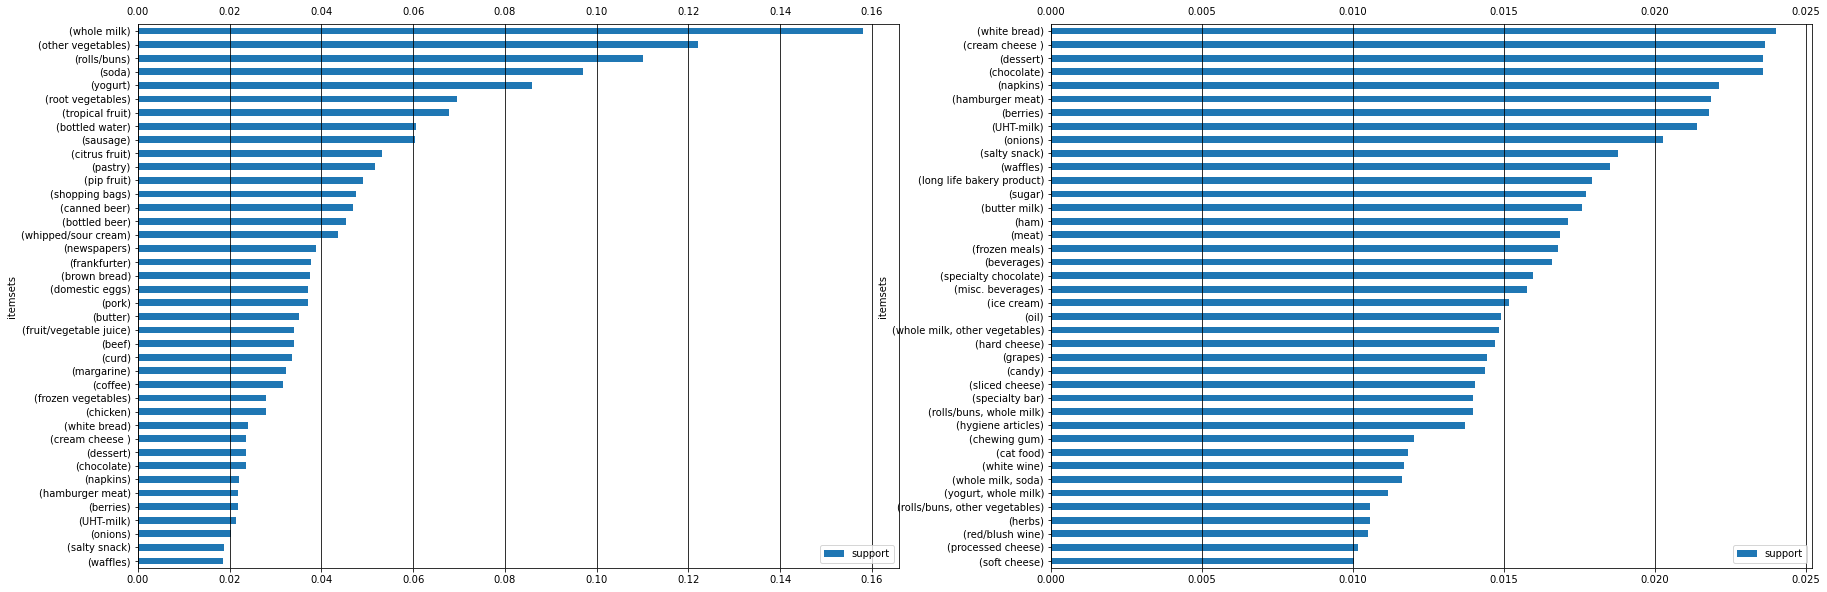

In [9]:
frequent_items = apriori(basket_sets, min_support=0.01, use_colnames=True)

frequent_items_to_plot = frequent_items.set_index("itemsets")
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

frequent_items_to_plot.sort_values("support", ascending=False).head(40).sort_values("support").plot(kind="barh", ax=ax[0])  # 1 - 50 most frequent items
frequent_items_to_plot.sort_values("support", ascending=False).tail(40).sort_values("support").plot(kind="barh", ax=ax[1])  # 50 - 100 frequent items
ax[0].grid(axis="x", color="black")
ax[0].tick_params(labelbottom=True, labeltop=True)
ax[1].grid(axis="x", color="black")
ax[1].tick_params(labelbottom=True, labeltop=True)

### Rules

Below we can se rules made by the algorithm, which uses low threshold values to allow me to comment on the results, as high value of threshold would result in no rules at all, as rules present in this dataset are insignificant. For every rules there are 5 evaluation metrics calculated:
 - <b>antecedent support [0,1]</b> - percent of transactions containing antecedent;
 - <b>consequent support [0,1]</b> - percent of transactions containing consequent;
 - <b>support [0,1]</b> - percent of transactions containing combined antecedent and consequent;
 - <b>confidence [0,1]</b> - probability of seeing the consequent in a transaction given that it also contains the antecedent - the higher, the better;
 - <b>lift [0, inf] </b> - how much more often the antecedent and consequent of a rule occur together, than we would expect if they were statistically independent. For independent rules it is equal to 1;
 - <b>leverage [-1, 1]</b> - the difference between the observed frequency of antecedent and consequent appearing together and the frequency that would be expected if antecedent and consequent were independent. For independent rules it is equal to 0;
 - <b>conviction [0, inf]</b> - for high conviction consequent is highly dependent on antecedent. 1) For independent items it is equal to 1. 2) For perfect score it is equal to infinity.

In [10]:
rules = association_rules(frequent_items, metric="confidence", min_threshold=0.05)  # set low threshold to analyse
rules.sort_values("lift", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
8,(yogurt),(whole milk),0.085879,0.157923,0.011161,0.129961,0.822940,-0.002401,0.967861
9,(whole milk),(yogurt),0.157923,0.085879,0.011161,0.070673,0.822940,-0.002401,0.983638
4,(rolls/buns),(whole milk),0.110005,0.157923,0.013968,0.126974,0.804028,-0.003404,0.964550
5,(whole milk),(rolls/buns),0.157923,0.110005,0.013968,0.088447,0.804028,-0.003404,0.976350
1,(other vegetables),(rolls/buns),0.122101,0.110005,0.010559,0.086481,0.786154,-0.002872,0.974249
0,(rolls/buns),(other vegetables),0.110005,0.122101,0.010559,0.095990,0.786154,-0.002872,0.971117
3,(other vegetables),(whole milk),0.122101,0.157923,0.014837,0.121511,0.769430,-0.004446,0.958551
2,(whole milk),(other vegetables),0.157923,0.122101,0.014837,0.093948,0.769430,-0.004446,0.968928
6,(whole milk),(soda),0.157923,0.097106,0.011629,0.073635,0.758296,-0.003707,0.974663
7,(soda),(whole milk),0.097106,0.157923,0.011629,0.119752,0.758296,-0.003707,0.956636


<Figure size 720x360 with 0 Axes>

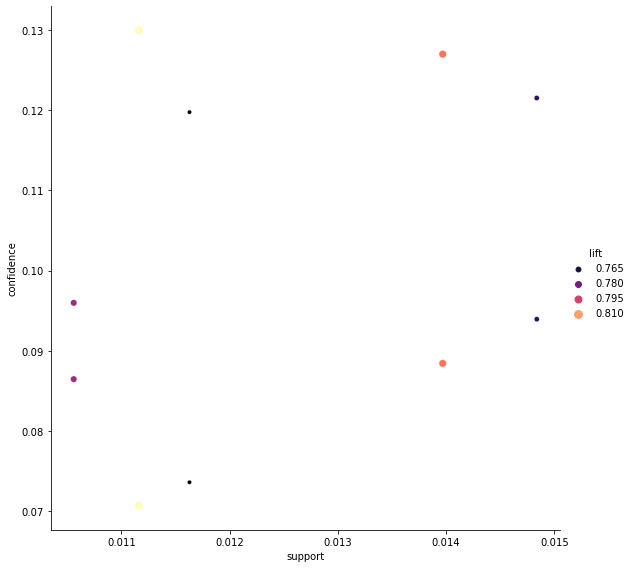

In [11]:
plt.figure(figsize=(10, 5))

sns.relplot(x="support", y="confidence", data=rules, size='lift', hue="lift", height=8, palette="magma")

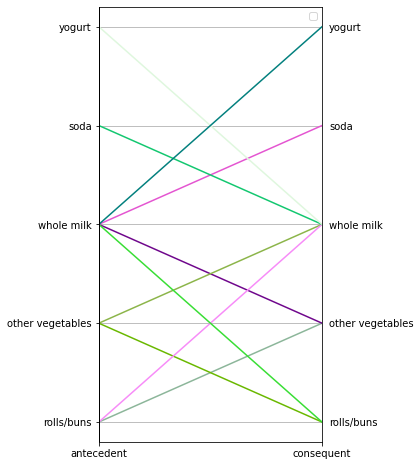

In [12]:
from pandas.plotting import parallel_coordinates


def rules_to_coordinates(rules):
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
    rules['rule'] = rules.index
    return rules[['antecedent','consequent','rule']]


coords = rules_to_coordinates(rules)

# Generate parallel coordinates plot
plt.figure(figsize=(4,8))
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.grid(True)
plt.tick_params(labelleft=True, labelright=True)
plt.show()
